# Binary phase evaluation 

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2\pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad, simps 
from scipy.special import hyp2f1, betainc
import pandas as pd
import seaborn as sns

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

In [3]:
class Phase_Evaluation:
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, gammas, rho6, r6, epsv): 
        
        # Binary params:
        self.m1 = m1
        self.m2 = m2
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.M_tot = self.m1 + self.m2
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
        
        # Accretion Disk params:
        self.mach = mach
        self.r0 = 6 * self.G * self.m1 / self.c**2 # 3 * r_schwarzschild
        self.sigma0 = sigma0 / self.mach**2
        self.alpha = alpha
        
        # Dark matter spike params:
        self.logL = 1 / np.sqrt(self.q)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        
    #----- Basic functions for profiles and frequency domain ----
        
    def rho_dm(self, r):
        '''Finds the density profile of the dark matter using the above formulation.'''
        return self.rho6 * (self.r6 / r)**(self.alpha)
    
    def sigma_acc(self, r): 
        '''Finds the surface density profile of an accretion disk.'''
        return self.sigma0 * (r / self.r0)**(self.alpha)

    def rho_disk(self, r):
        '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
        h = r / self.mach
        return self.sigma_acc(r) / (2 * h) 

    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return np.sqrt(self.G * self.m1 / r**3) / np.pi 
    
    def radius(self, f):
        '''Finds the binary radius assuming circular orbits, at fixed frequency f.'''
        return (self.G * self.M_tot / (np.pi**2 * f**2))**(1/3)

    def df_dr(self, r): 
        '''Finds the binary frequency radial derivative assuming circular orbits.'''
        return -1.5 * np.sqrt(self.G * self.m1 / r**5) / np.pi

    def gas_torque(self, r): 
        '''Finds the gas torque on the secondary.'''
        return - self.sigma_acc(r) * r**4 * np.sqrt(self.G * self.M_tot / r**3) * self.q**2 * self.mach**2
    
    #---- Analytic phase evaluation -----
    
    def vacuum_phase(self, r):
        '''Analytical vacuum phase solution.'''
        freqs = self.frequency(r)
        r_isco = 6 * self.m1 * self.G / self.c**2
        f_isco = self.frequency(r_isco)
        return -self.G**(-5/3) * (self.M_tot)**(1/3) * self.c**5 / (16 * np.pi**(5/3) * self.m1 * self.m2) * (freqs**(-5/3) - f_isco**(-5/3))

    def dvacuum_phase_df(self, r):
        '''Analytical derivation of vacuum phase solution.'''
        freqs = self.frequency(r)
        return -self.G**(-5/3) * (self.M_tot)**(1/3) * self.c**5 / (16 * np.pi**(5/3) * self.m1 * self.m2) * (-5/3) * (freqs**(-5/3-1))
                
    def hyp2f1_derivative(self, hyp2f1, f):
        '''Finds derivative of the gauss_hypergeom function through differentiation.'''
        delta_function = np.concatenate(([np.min(hyp2f1)], hyp2f1[1:] - hyp2f1[:-1]))
        delta_fs = np.concatenate(([np.max(f)], f[1:] - f[:-1]))
        return delta_function/delta_fs
    
    #----- From GitHub pydd (attempt at correction) ---
    
    def get_r_s(self, m_1, rho_s, gamma_s):
        return ((3 - gamma_s) * 0.2 ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    
    def get_rho_s(self, rho_6, m_1, gamma_s):
        a = 0.2
        r_6 = 1e-6 * self.pc
        m_tilde = ((3 - gamma_s) * a ** (3 - gamma_s)) * m_1 / (2 * np.pi)
        return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))

    
    def find_dot_r_effDM(self, r):
    
        '''Find the dor_r_eff from reversed process from analytical phi_eff(f).'''

        freqs = self.frequency(r)
        df_dr_s = self.df_dr(r)
        
        # Vacuum 
        
        phase_vacuum = self.vacuum_phase(r)
        dphase_vacuum_df = self.dvacuum_phase_df(r)
        
        # Constants
        
        rho_s = self.get_rho_s(self.rho6, self.m1, self.gammas)
        r_s = self.get_r_s(self.m1, rho_s, self.gammas)
        
        gamma_e = 5/2 
        theta = 5 / (2 * gamma_e)
        c_f = 5 * self.c**5 / (8 * self.m1**2) * np.pi**(2 * (self.gammas - 4) / 3) * self.G**(- (2 + self.gammas)/3) * self.M_tot**((1 - self.gammas) / 3) *\
        r_s**(self.gammas) * self.epsv * rho_s * self.logL
        f_eq = c_f**(3 / (11 - 2 * self.gammas))
        lambda_ = (11 - 2 * (self.gammas + gamma_e)) / 3
        f_b = 0.8163 * (self.m1 / (1000 * self.m_sun))**(-1.4412) * (self.m2 / self.m_sun)**(0.4511) * (1 - 0.4971 * np.log(self.gammas / 1.4396))
        eta = (5 + 2 * gamma_e) / (2 * (8 - self.gammas)) * (f_eq / f_b)**((11 - 2 * self.gammas) / 3)
        f_t = f_b
        
        # Variables 
    
        y = freqs / f_t
        dy_df = 1 / f_t
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        dgauss_hypergeom_df = self.hyp2f1_derivative(gauss_hypergeom, freqs)
        
        # Find phase derivative in frequency
        
        exp_y = y**(-lambda_)
        d_phase_df_s = dphase_vacuum_df - (dphase_vacuum_df * eta * exp_y + phase_vacuum * eta * (-lambda_) * exp_y/y * dy_df) +\
        eta * (-lambda_ * exp_y/y * phase_vacuum * dy_df * gauss_hypergeom + exp_y * dphase_vacuum_df * gauss_hypergeom + exp_y * phase_vacuum * dgauss_hypergeom_df)
        
        df_dt = 2 * np.pi * freqs / d_phase_df_s
        return df_dt * df_dr_s**(-1)
    
    
    #-------- Dot_r -----------
    
    def dot_r_all(self, r):
        '''Finds the derivative of radial separation within a mixed environment.'''
        r_dot_dm = self.find_dot_r_effDM(r)
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        return r_dot_dm + r_dot_acc
    
    def dot_r_all_s(self, r):
        '''Finds the derivative of radial separation within a mixed environment (DM is static).'''
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        return r_dot_gw + r_dot_dm + r_dot_acc
    
    def dot_r_acc(self, r):
        '''Finds the derivative of radial separation within an accretion disk.'''
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        return r_dot_gw + r_dot_acc
    
    def dot_r_dm(self, r):
        '''Finds the derivative of radial separation within a dynamic dark matter environment.'''
        return self.find_dot_r_effDM(r)
    
    def dot_r_dm_s(self, r):
        '''Finds the derivative of radial separation within a static dark matter environment.'''
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        return r_dot_gw + r_dot_dm
        
    def dot_r_gw(self, r):
        '''Finds the derivative of radial separation in the vacuum case.'''
        return - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
    
    #------ df/dt ------
    
    def df_dt_all(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_all(r)
    
    def df_dt_all_s(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_all_s(r)
    
    def df_dt_acc(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_acc(r)
    
    def df_dt_dm(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_dm(r)
    
    def df_dt_dm_s(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_dm_s(r)
    
    def df_dt_gw(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_gw(r)
    
    # ---- Numerical phase evaluation -------
    
    def phase_f_by_hand_all(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_all(r)**(-1) * freqs 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)
    
    def phase_f_by_hand_all_s(self, r): 
        '''Finds the binary phase as a function of frequency (static DM).'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_all_s(r)**(-1) * self.frequency(r) 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)
    
    def phase_f_by_hand_acc(self, r): 
        '''Finds the binary phase as a function of frequency (accretion only).'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_acc(r)**(-1) * self.frequency(r) 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)
    
    def phase_f_by_hand_dm(self, r): 
        '''Finds the binary phase as a function of frequency (efficient DM only).'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_dm(r)**(-1) * self.frequency(r) 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)
    
    def phase_f_by_hand_dm_s(self, r): 
        '''Finds the binary phase as a function of frequency (static DM only).'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_dm_s(r)**(-1) * self.frequency(r) 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)
    
    def phase_f_by_hand_gw(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_gw(r)**(-1) * self.frequency(r) 
        phase_f = []
        for b in freqs:  # range of values for the lower limit
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
        return np.array(phase_f)

In [4]:
# Use this class to check consistency of results

class Phase_Evaluation_check: 
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, gammas, rho6, r6, epsv): 
        
        # Binary params:
        self.m1 = m1
        self.m2 = m2
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.M_tot = self.m1 + self.m2
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
        
        # Accretion Disk params:
        self.mach = mach
        self.r0 = 6 * self.G * self.m1 / self.c**2 # 3 * r_schwarzschild
        self.sigma0 = sigma0 / self.mach**2
        self.alpha = alpha
        
        # Dark matter spike params:
        self.logL = 1 / np.sqrt(self.q)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        
    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return np.sqrt(self.G * self.m1 / r**3) / np.pi 
    
    def hypgeom_scipy(self, a, x):
        '''Compute the hypergeometric function using scipy.'''
        return hyp2f1(1, a, 1 + a, x)

    def _Phi_to_c_indef_s(self, r):
        '''Compute something with constants and functions.'''
        freqs = self.frequency(r)
        c_f = 5 * c**5 / (8 * self.m1**2) * np.pi**(2 * (self.gammas - 4) / 3) * self.G**(- (2 + self.gammas)/3) * self.M_tot**((1 - self.gammas) / 3) * self.r6**(self.gammas) * self.epsv * self.rho6 * self.logL
        f_eq =  c_f ** (3 / (11 - 2 * self.gammas))
        a_v = 1 / 16 * (self.c ** 3 / (np.pi * self.G * self.chirp_mass)) ** (5 / 3)
        x = freqs / f_eq
        th = 5 / (11 - 2 * self.gammas)
        return a_v / freqs ** (5 / 3) * self.hypgeom_scipy(th, -x ** (-5 / (3 * th)))
    
    def _Phi_to_c_s(self, r):
        '''Compute something with constants and functions.'''
        r_isco = 6 * self.m1 * self.G / c**2
        return self._Phi_to_c_indef_s(r) -  self._Phi_to_c_indef_s(r_isco)
    
    def phasePN(self, nu, v):
        '''Compute some phase related function.'''
        return (3715/1008 + 55 * nu /12) * v**2 - 10 * np.pi * v**3 +(15293365/1016064 + 27145 * nu /1008 + 3085 * nu**2 / 144) * v**4

    def _Phi_to_c_indef_v(self, r):
        '''Compute something else.'''
        freqs = self.frequency(r)
        nu1 = self.m1 * self.m2/(self.M_tot)**2
        v1 = ((self.G/self.c**3) * np.pi * (self.M_tot) * freqs)**(1/3)
        a_v = 1 / 16 * (self.c ** 3 / (np.pi * self.G * self.chirp_mass)) ** (5/3)
        PN = 0
        return a_v / freqs ** (5 / 3) * (1 + PN * self.phasePN(nu1, v1))
    
    def _Phi_to_c_v(self, r):
        '''Compute something with constants and functions.'''
        r_isco = 6 * self.m1 * self.G / c**2
        return self._Phi_to_c_indef_v(r) -  self._Phi_to_c_indef_v(r_isco)
    
    def get_r_s(self, m_1, rho_s, gamma_s):
        return ((3 - gamma_s) * 0.2 ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    
    def get_rho_s(self, rho_6, m_1, gamma_s):
        a = 0.2
        r_6 = 1e-6 * self.pc
        m_tilde = ((3 - gamma_s) * a ** (3 - gamma_s)) * m_1 / (2 * np.pi)
        return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))
    
    def phase_effective_dm(self, r):
    
        '''Finds the effective phase from fitting results from HaloFeedback algorithm.'''
        
        freqs = self.frequency(r)
        
        # Constants:
        
        rho_s = self.get_rho_s(self.rho6, self.m1, self.gammas)
        r_s = self.get_r_s(self.m1, rho_s, self.gammas)
        
        gamma_e = 5/2
        theta = 5 / (2 * gamma_e)
        c_f = 5 * self.c**5 / (8 * self.m1**2) * np.pi**(2 * (self.gammas - 4) / 3) * self.G**(- (2 + self.gammas)/3) * self.M_tot**((1 - self.gammas) / 3) *\
        r_s**(self.gammas) * self.epsv * rho_s * self.logL
        f_eq = c_f**(3 / (11 - 2 * self.gammas))
        lambda_ = (11 - 2 * (self.gammas + gamma_e)) / 3
        f_b = 0.8163 * (self.m1 / (1000 * self.m_sun))**(-1.4412) * (self.m2 / self.m_sun)**(0.4511) * (1 - 0.4971 * np.log(self.gammas / 1.4396))
        eta = (5 + 2 * gamma_e) / (2 * (8 - self.gammas)) * (f_eq / f_b)**((11 - 2 * self.gammas) / 3)
        
        # Variables:
        
        f_t = f_b
        y = freqs / f_t
        phase_vacuum = self._Phi_to_c_v(r)
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        
        return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

---

# Test 1) Reference models results

Define the models:

In [5]:
# Numerical

reference_model_1 = Phase_Evaluation(

    m1 = 1e5 * m_sun, 
    m2 = 10 * m_sun,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc
)


# Check

model_check_1 = Phase_Evaluation_check(

    m1 = 1e5 * m_sun, 
    m2 = 10 * m_sun,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc
)

### Phase to coalescence

In [6]:
def binary_separation(f, m1):
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
    return (G * m1 / (f**2 * np.pi**2))**(1/3)

In [7]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max = binary_separation(f_LISA, 1e5 * m_sun)
r_isco = 6 * 1e5 * m_sun * G / c**2
f_isco = reference_model_1.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, 10000)
freqs = reference_model_1.frequency(r_grid)

isco frequency 0.04397009835544326


In [8]:
phase_all = reference_model_1.phase_f_by_hand_all(r_grid)
phase_dm = reference_model_1.phase_f_by_hand_dm(r_grid)
phase_all_s = reference_model_1.phase_f_by_hand_all_s(r_grid)
phase_dm_s = reference_model_1.phase_f_by_hand_dm_s(r_grid)
phase_acc = reference_model_1.phase_f_by_hand_acc(r_grid)
phase_vacuum = reference_model_1.phase_f_by_hand_gw(r_grid)

In [9]:
phase_dm_s_check = model_check_1._Phi_to_c_s(r_grid) 
phase_vacuum_check = model_check_1._Phi_to_c_v(r_grid)
phase_dm_check = model_check_1.phase_effective_dm(r_grid)

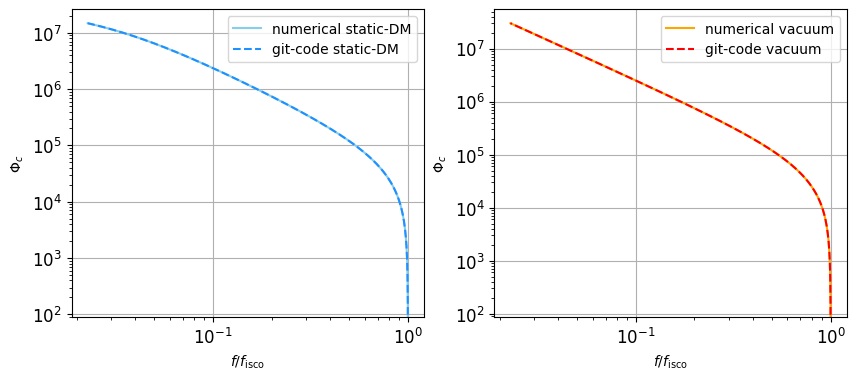

In [10]:
# Check if the analytical and numerical overlap
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].loglog(freqs/f_isco, -phase_dm_s, c='skyblue', linestyle='-', label='numerical static-DM')
ax[0].loglog(freqs/f_isco, phase_dm_s_check, linestyle='--', label='git-code static-DM', c='dodgerblue')
ax[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[0].tick_params(axis='x', labelsize=12)  
ax[0].tick_params(axis='y', labelsize=12)  
ax[0].grid(True)
ax[0].legend()

ax[1].loglog(freqs/f_isco, -phase_vacuum, c='orange', linestyle='-', label='numerical vacuum')
ax[1].loglog(freqs/f_isco, phase_vacuum_check, linestyle='--', label='git-code vacuum', c='red')
ax[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[1].tick_params(axis='x', labelsize=12)  
ax[1].tick_params(axis='y', labelsize=12)  
ax[1].grid(True)
ax[1].legend();

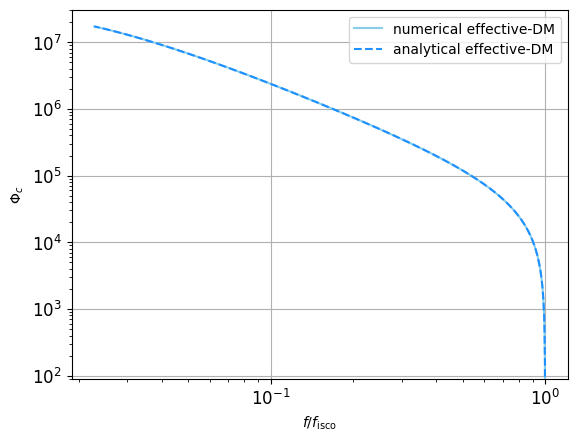

In [11]:
plt.loglog(freqs/f_isco, -phase_dm, c='skyblue', linestyle='-', label='numerical effective-DM')
plt.loglog(freqs/f_isco, phase_dm_check, c='dodgerblue', linestyle='--', label='analytical effective-DM')
plt.xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
plt.ylabel(r'$\Phi_c$', fontsize=10) 
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

### Dephasing

We will see the plots of: 
    
- $\Delta\Phi_{\mathrm{all, s}} = \Phi_{\mathrm{all, s, c}} - \Phi_{\mathrm{vac, c}}$ (static dark matter);
- $\Delta\Phi_{\mathrm{all}} = \Phi_{\mathrm{all, c}} - \Phi_{\mathrm{vac, c}}$ (effective dark matter);
- $\Delta\Phi_{\mathrm{dm, s}} = \Phi_{\mathrm{dm, s, c}} - \Phi_{\mathrm{vac, c}}$ (static dark matter);
- $\Delta\Phi_{\mathrm{dm}} = \Phi_{\mathrm{dm, c}} - \Phi_{\mathrm{vac, c}}$ (effective dark matter);
- $\Delta\Phi_{\mathrm{acc}} = \Phi_{\mathrm{acc, c}} - \Phi_{\mathrm{vac, c}}$;

In [12]:
delta_all = phase_all - phase_vacuum
delta_all_s = phase_all_s - phase_vacuum
delta_dm = phase_dm - phase_vacuum
delta_dm_s = phase_dm_s - phase_vacuum
delta_acc = phase_acc - phase_vacuum

In [13]:
# Convert in N_cycles

Nc_all = delta_all/(2 * np.pi)
Nc_all_s = delta_all_s/(2 * np.pi)
Nc_dm = delta_dm/(2 * np.pi)
Nc_dm_s = delta_dm_s/(2 * np.pi)
Nc_acc = delta_acc/(2 * np.pi)

In [14]:
# Define a custom color palette
custom_palette = sns.color_palette(["#4c72b0", "#55a868", "#c44e52", "#ffcc66"])

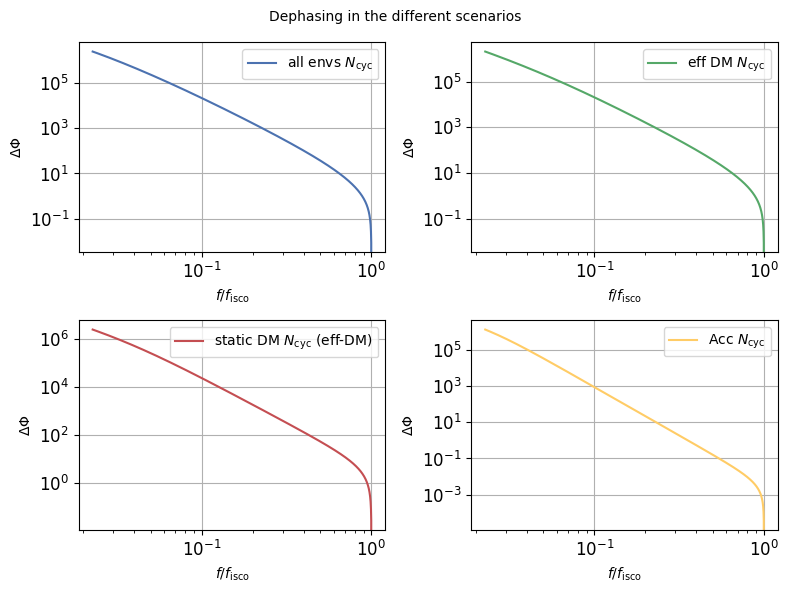

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs/f_isco, Nc_all, c=custom_palette[0], linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs/f_isco, Nc_dm, c=custom_palette[1], linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs/f_isco, Nc_dm_s, c=custom_palette[2], linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs/f_isco, Nc_acc, c=custom_palette[3], linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout();

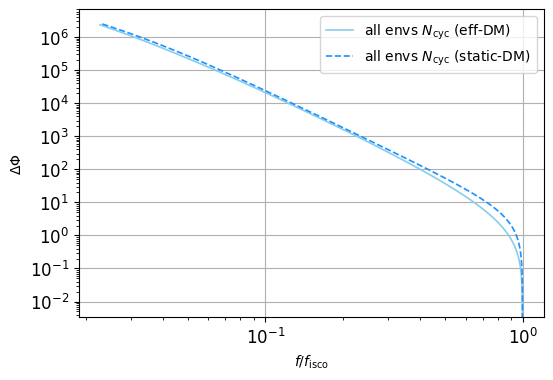

In [16]:
# Compare the all-environments to see difference between DM profiles

plt.figure(figsize=(6, 4))

plt.loglog(freqs/f_isco, Nc_all, c='skyblue', linestyle='-', label='all envs $N_{\mathrm{cyc}}$ (eff-DM)', linewidth=1.2)
plt.loglog(freqs/f_isco, Nc_all_s, c='dodgerblue', linestyle='--', label='all envs $N_{\mathrm{cyc}}$ (static-DM)', linewidth=1.2)
plt.xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
plt.ylabel(r'$\Delta\Phi$', fontsize=10) 
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

Slightly above as expected, the static profle has a stronger effect on binary coalscence.  

--- 

# Test 2) Multiple model parameters

We now work using the same functions as in the previous section, only varying parameters one by one (see also more specific work in $\texttt{Phase_extraction_DM_vs_Acc.ipynb}$). More specifically we'll change:

### For the accretion disk:

- The $\alpha$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$). In the $\texttt{Phase_extraction_CLASS}$ notebook I saw different plots varying just one parameter. In this one I will vary two parameters contemporarily and see how this affects the dephasing. 

## Density normalizations ($\Sigma_0 \text{ vs } \rho_6$)

In [17]:
sigma_0_i = np.logspace(8, 11, 10)
rho_s_i = np.logspace(15, 18, 10)

In [18]:
# Define models based on params

models_density = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0_i[i], 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_s_i[j] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0_i))] for j in range(0, len(rho_s_i))] 

### Phase to coalescence $\rightarrow$ dephasing

Note: execute the next cell only if you're sure you want changes, as it takes a while ($\sim 3/4$ minutes).

In [19]:
# Phase to coalescence

phase_all_s_dense = [[(models_density[i][j].phase_f_by_hand_all_s(r_grid)) for i in range(0, len(models_density))] for j in range(0, len(models_density))]
phase_all_dense = [[(models_density[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(models_density))] for j in range(0, len(models_density))]
phase_vacuum_dense = [[(models_density[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(models_density))]  for j in range(0, len(models_density))]

In [20]:
# Dephasing 

delta_all_dense = np.array(phase_all_dense) - np.array(phase_vacuum_dense)
delta_all_s_dense = np.array(phase_all_s_dense) - np.array(phase_vacuum_dense)

Nc_all_dense = delta_all_dense/(2 * np.pi)
Nc_all_s_dense = delta_all_s_dense/(2 * np.pi)

In [21]:
# select components to see on plot

n_comp_to_see = [100, 1000, 2000, 4000, 6000, 7000, 8000, 9000, 9999]

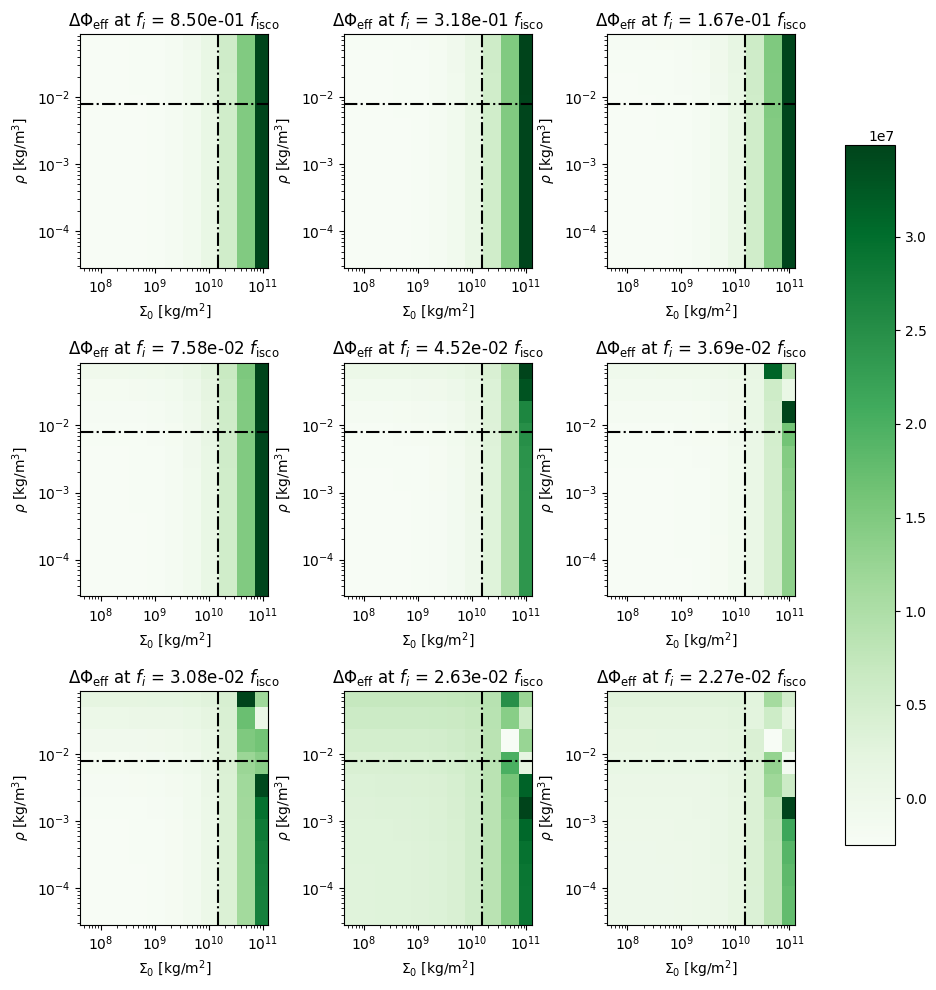

In [22]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(sigma_0_i, rho_s_i  * m_sun / (pc)**3, Nc_all_dense[:, :, i], cmap='Greens') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=1.17 * 1e17 * m_sun / (pc)**3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=1.5 * 1e10, c='black', linestyle='-.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities_eff.png')

plt.show()

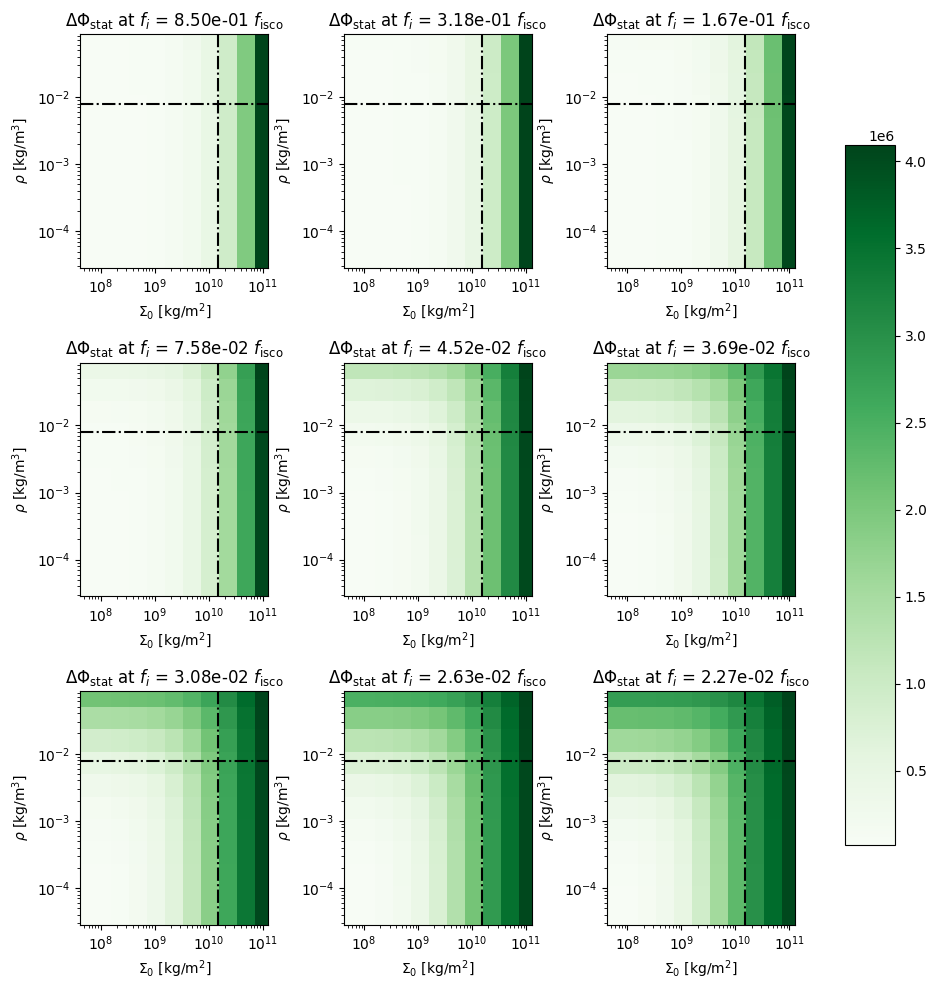

In [23]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(sigma_0_i, rho_s_i  * m_sun / (pc)**3, Nc_all_s_dense[:, :, i], cmap='Greens') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=1.17 * 1e17 * m_sun / (pc)**3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=1.5 * 1e10, c='black', linestyle='-.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{stat}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities_static.png')

plt.show()

## Density slopes ($\gamma_s \text{ vs } \alpha$)

In [24]:
alpha_i = np.linspace(-0.7, 1.5, 10)
gamma_s_i = np.linspace(1, 3, 10)

In [25]:
models_slope = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = alpha_i[i], 
    gammas = gamma_s_i[j], 
    rho6 =  1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(alpha_i))] for j in range(0, len(gamma_s_i))] 

### Phase to coalescence $\rightarrow$ dephasing

Note: execute the next cell only if you're sure you want changes, as it takes a while ($\sim 3/4$ minutes).

In [26]:
# Phase to coalescence

phase_all_s_slope = [[(models_slope[i][j].phase_f_by_hand_all_s(r_grid)) for i in range(0, len(models_slope))] for j in range(0, len(models_slope))]
phase_all_slope = [[(models_slope[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(models_slope))] for j in range(0, len(models_slope))]
phase_vacuum_slope = [[(models_slope[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(models_slope))]  for j in range(0, len(models_slope))]

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_19417/1170661644.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_19417/1170661644.py:114: RuntimeWarning: invalid value encountered in scalar multiply
  c_f = 5 * self.c**5 / (8 * self.m1**2) * np.pi**(2 * (self.gammas - 4) / 3) * self.G**(- (2 + self.gammas)/3) * self.M_tot**((1 - self.gammas) / 3) *\


In [27]:
# Dephasing 

delta_all_slope = np.array(phase_all_slope) - np.array(phase_vacuum_slope)
delta_all_s_slope = np.array(phase_all_s_slope) - np.array(phase_vacuum_slope)

Nc_all_slope = delta_all_slope/(2 * np.pi)
Nc_all_s_slope = delta_all_s_slope/(2 * np.pi)

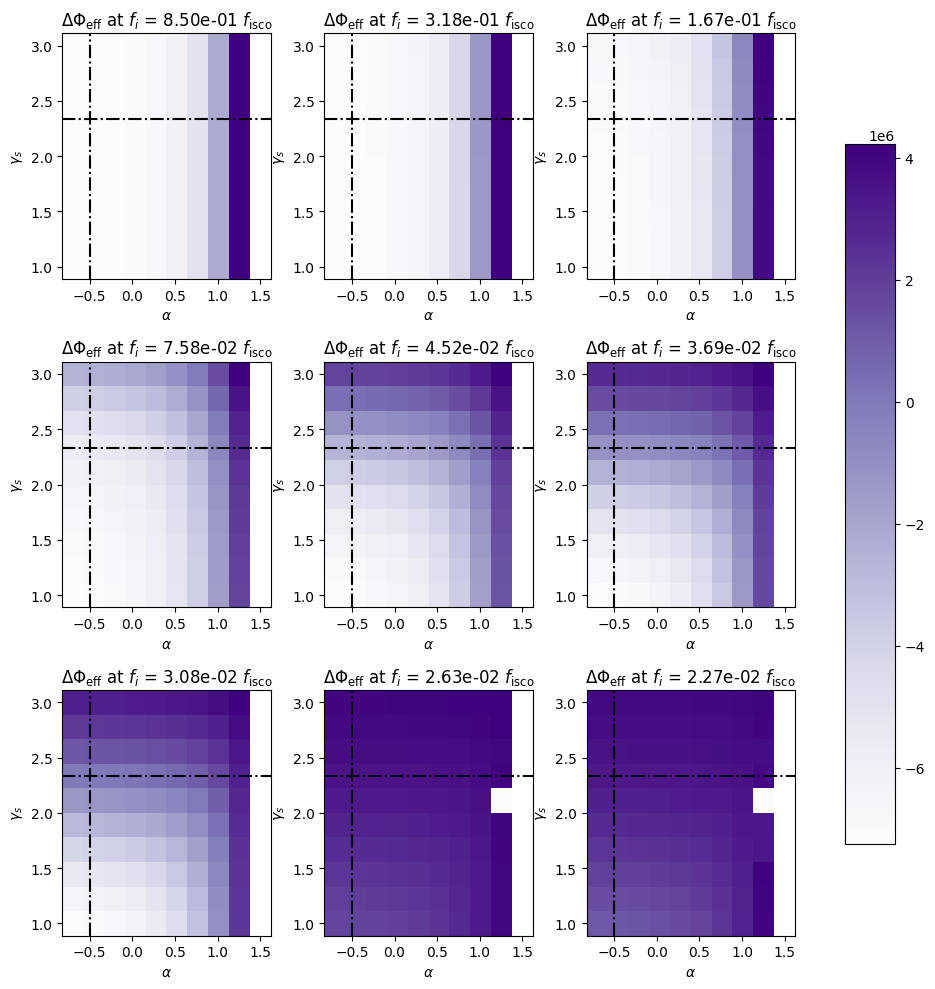

In [28]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(alpha_i, gamma_s_i, Nc_all_slope[:, :, i], cmap='Purples') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=7/3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=-0.5,c='black', linestyle='-.',)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\gamma_s$')
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_slopes-eff.png')

plt.show()

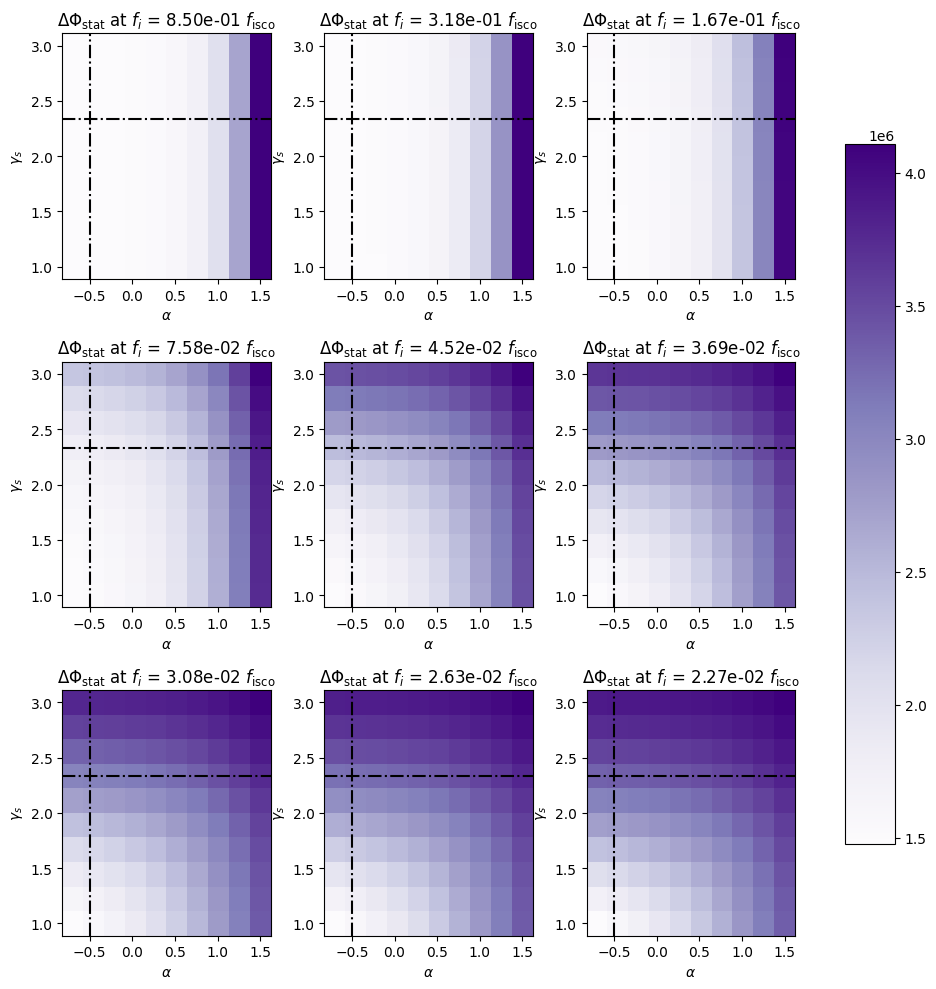

In [29]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(alpha_i, gamma_s_i, Nc_all_s_slope[:, :, i], cmap='Purples') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=7/3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=-0.5,c='black', linestyle='-.',)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\gamma_s$')
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{stat}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_slopes-static.png')

plt.show()

Since I see weird things happening at $f << f_{\mathrm{isco}}$ I now will check some plots of the dephase, fixing one of the two params. 

- Slope check

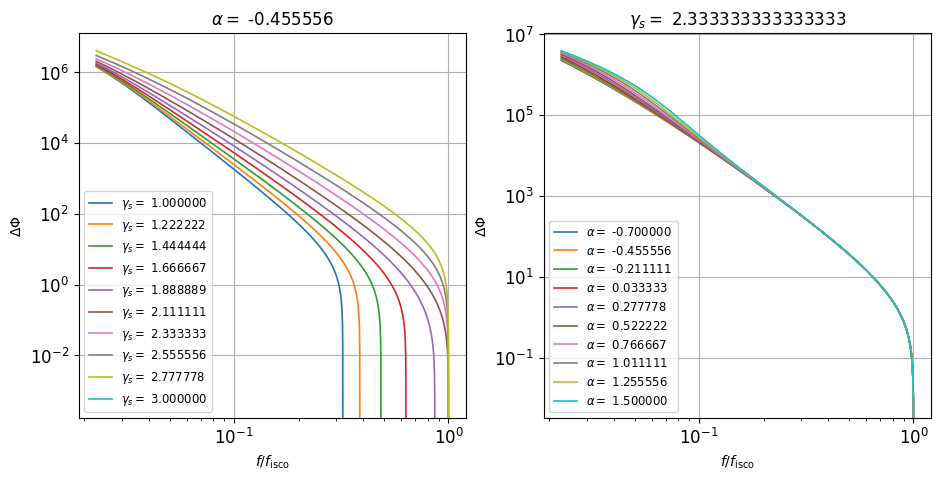

In [30]:
# Check multiple slope dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 10):
    
    axes[0].loglog(freqs/f_isco, Nc_all_slope[1, i, :], linestyle='-', label=f'$\gamma_s =$ {gamma_s_i[i]:2f}', linewidth=1.2)
    
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\alpha = $ {alpha_i[1]:2f}')
axes[0].legend(fontsize='small')

for i in range(0, 10):
    
    axes[1].loglog(freqs/f_isco, Nc_all_slope[i, 6, :], linestyle='-', label=fr'$\alpha =$ {alpha_i[i]:2f}', linewidth=1.2)
    
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\gamma_s =$ {gamma_s_i[6]}')
axes[1].legend(fontsize='small');

There seems that if we vary the params there can exist situations where we do not have shrinking but the opposite??

- Normalization check

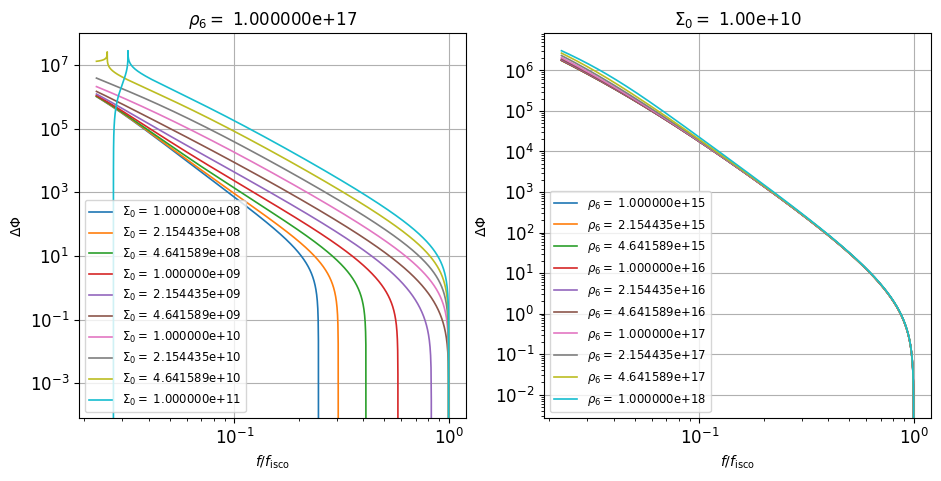

In [31]:
# Check multiple norm dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 10):
    
    axes[0].loglog(freqs/f_isco, Nc_all_dense[6, i, :], linestyle='-', label=f'$\Sigma_0 =$ {sigma_0_i[i]:2e}', linewidth=1.2)
    
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\rho_6 = $ {rho_s_i[6]:2e}')
axes[0].legend(fontsize='small')

for i in range(0, 10):
    
    axes[1].loglog(freqs/f_isco, Nc_all_dense[i, 6, :], linestyle='-', label=fr'$\rho_6 =$ {rho_s_i[i]:2e}', linewidth=1.2)
    
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\Sigma_0 =$ {sigma_0_i[6]:.2e}')
axes[1].legend(fontsize='small');

How to comment on this?

---

## Check on a different model:

In [32]:
# Use git function

def get_rho_6(rho_s, m_1, gamma_s):
    a = 0.2
    r_s = ((3 - gamma_s) * a ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    r_6 = 1e-6 * pc
    return rho_s * (r_6 / r_s) ** -gamma_s

In [33]:
rho_6_2 = get_rho_6(226 * m_sun / (pc)**3, 1.4 * 1e3 * m_sun, 7/3)
print(rho_6_2)

0.00047908573198146895


In [34]:
# Numerical

reference_model_2 = Phase_Evaluation(

    m1 = 1.4 * 1e3 * m_sun, 
    m2 = 1.4 * m_sun,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_6_2, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc
)


# Check

model_check_2 = Phase_Evaluation_check(

    m1 = 1.4 * 1e3 * m_sun, 
    m2 = 1.4 * m_sun,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_6_2, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc
)

### Phase to coalescence

Set a new grid fit for the analysis of this second model:

In [35]:
# Build grid of vals

r_max_2 = binary_separation(f_LISA, 1.4 * 1e3 * m_sun)
r_isco_2 = 6 * 1.4 * 1e3 * m_sun * G / c**2
f_isco_2 = reference_model_2.frequency(r_isco_2)

print('isco frequency', f_isco_2)

# set grid of radial distances
r_grid_2 = np.linspace(r_isco_2, r_max_2, 10000)
freqs_2 = reference_model_2.frequency(r_grid_2)

isco frequency 3.140721311103091


In [36]:
phase_all2 = reference_model_2.phase_f_by_hand_all(r_grid_2)
phase_dm2 = reference_model_2.phase_f_by_hand_dm(r_grid_2)
phase_all_s2 = reference_model_2.phase_f_by_hand_all_s(r_grid_2)
phase_dm_s2 = reference_model_2.phase_f_by_hand_dm_s(r_grid_2)
phase_acc2 = reference_model_2.phase_f_by_hand_acc(r_grid_2)
phase_vacuum2 = reference_model_2.phase_f_by_hand_gw(r_grid_2)

In [37]:
phase_dm_s_check2 = model_check_2._Phi_to_c_s(r_grid_2) 
phase_vacuum_check2 = model_check_2._Phi_to_c_v(r_grid_2)
phase_dm_check2 = model_check_2.phase_effective_dm(r_grid_2)

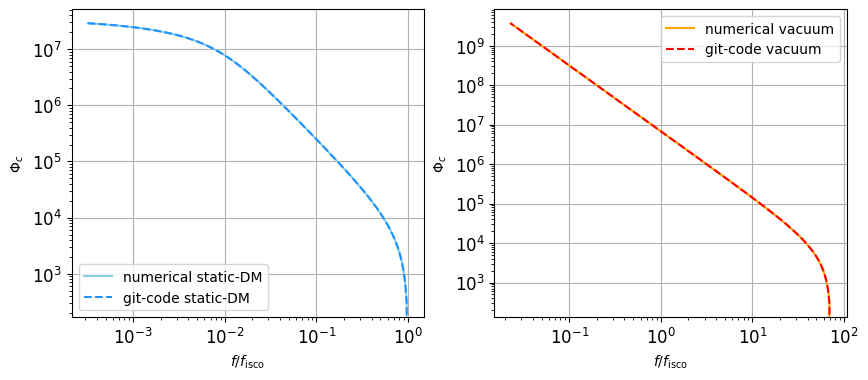

In [38]:
# Check if the analytical and numerical overlap
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].loglog(freqs_2/f_isco_2, -phase_dm_s2, c='skyblue', linestyle='-', label='numerical static-DM')
ax[0].loglog(freqs_2/f_isco_2, phase_dm_s_check2, linestyle='--', label='git-code static-DM', c='dodgerblue')
ax[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[0].tick_params(axis='x', labelsize=12)  
ax[0].tick_params(axis='y', labelsize=12)  
ax[0].grid(True)
ax[0].legend()

ax[1].loglog(freqs_2/f_isco, -phase_vacuum2, c='orange', linestyle='-', label='numerical vacuum')
ax[1].loglog(freqs_2/f_isco, phase_vacuum_check2, linestyle='--', label='git-code vacuum', c='red')
ax[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[1].tick_params(axis='x', labelsize=12)  
ax[1].tick_params(axis='y', labelsize=12)  
ax[1].grid(True)
ax[1].legend();

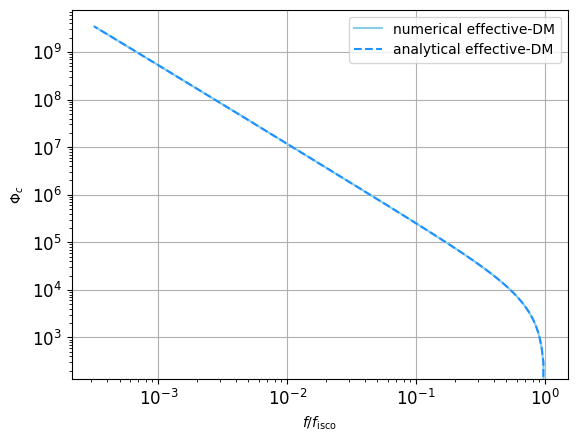

In [39]:
plt.loglog(freqs_2/f_isco_2, -phase_dm2, c='skyblue', linestyle='-', label='numerical effective-DM')
plt.loglog(freqs_2/f_isco_2, phase_dm_check2, c='dodgerblue', linestyle='--', label='analytical effective-DM')
plt.xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
plt.ylabel(r'$\Phi_c$', fontsize=10) 
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

### Dephasing

We will see the plots of: 
    
- $\Delta\Phi_{\mathrm{all, s}} = \Phi_{\mathrm{all, s, c}} - \Phi_{\mathrm{vac, c}}$ (static dark matter);
- $\Delta\Phi_{\mathrm{all}} = \Phi_{\mathrm{all, c}} - \Phi_{\mathrm{vac, c}}$ (effective dark matter);
- $\Delta\Phi_{\mathrm{dm, s}} = \Phi_{\mathrm{dm, s, c}} - \Phi_{\mathrm{vac, c}}$ (static dark matter);
- $\Delta\Phi_{\mathrm{dm}} = \Phi_{\mathrm{dm, c}} - \Phi_{\mathrm{vac, c}}$ (effective dark matter);
- $\Delta\Phi_{\mathrm{acc}} = \Phi_{\mathrm{acc, c}} - \Phi_{\mathrm{vac, c}}$;

In [40]:
delta_all2 = phase_all2 - phase_vacuum2
delta_all_s2 = phase_all_s2 - phase_vacuum2
delta_dm2 = phase_dm2 - phase_vacuum2
delta_dm_s2 = phase_dm_s2 - phase_vacuum2
delta_acc2 = phase_acc2 - phase_vacuum2

In [41]:
# Convert in N_cycles

Nc_all2 = delta_all2/(2 * np.pi)
Nc_all_s2 = delta_all_s2/(2 * np.pi)
Nc_dm2 = delta_dm2/(2 * np.pi)
Nc_dm_s2 = delta_dm_s2/(2 * np.pi)
Nc_acc2 = delta_acc2/(2 * np.pi)

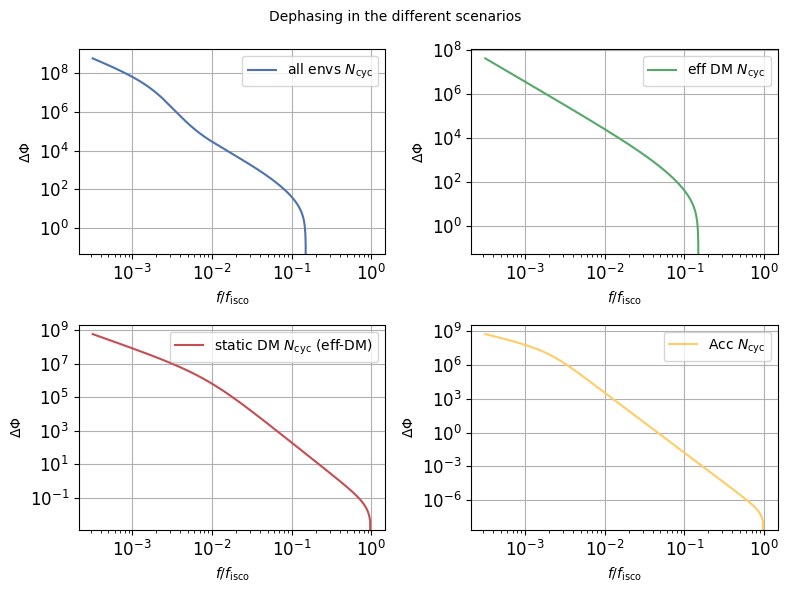

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs_2/f_isco_2, Nc_all2, c=custom_palette[0], linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs_2/f_isco_2, Nc_dm2, c=custom_palette[1], linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs_2/f_isco_2, Nc_dm_s2, c=custom_palette[2], linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs_2/f_isco_2, Nc_acc2, c=custom_palette[3], linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout();

Let's see the phase to coalescence in the effective dark matter case compared to the vacuum case and the static dark matter case. 

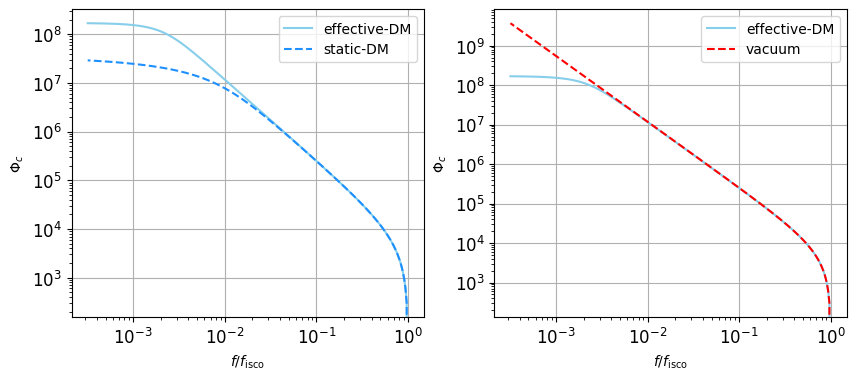

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].loglog(freqs_2/f_isco_2, -phase_all2, c='skyblue', linestyle='-', label='effective-DM')
ax[0].loglog(freqs_2/f_isco_2, -phase_dm_s2, linestyle='--', label='static-DM', c='dodgerblue')
ax[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[0].tick_params(axis='x', labelsize=12)  
ax[0].tick_params(axis='y', labelsize=12)  
ax[0].grid(True)
ax[0].legend()

ax[1].loglog(freqs_2/f_isco_2, -phase_all2, c='skyblue', linestyle='-', label='effective-DM')
ax[1].loglog(freqs_2/f_isco_2, -phase_vacuum2, linestyle='--', label='vacuum', c='red')
ax[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[1].tick_params(axis='x', labelsize=12)  
ax[1].tick_params(axis='y', labelsize=12)  
ax[1].grid(True)
ax[1].legend();